<a href="https://colab.research.google.com/github/hsalva2/XEMA/blob/main/Examen_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Machine Learning & Generalized Random Forests

In [ ]:
!pip install econml

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.dml import LinearDML, SparseLinearDML, CausalForestDML, NonParamDML
from econml.grf import CausalForest

In [21]:
# Load the experiment dataset
datos = pd.read_csv('https://raw.githubusercontent.com/carlosquintanillaa/automl/refs/heads/main/hojas/estdf1.csv')
nuevos = pd.read_csv('https://raw.githubusercontent.com/carlosquintanillaa/automl/refs/heads/main/hojas/estdf3.csv')

In [22]:
datos.head()


,id,X1,X2,X3,X4,T,Y
0,100001,-1.085631,0.997345,0,0,0,2.074016
1,100002,0.282978,-1.506295,0,0,0,1.715242
2,100003,-0.578600,1.651437,1,1,1,5.445697
3,100004,-2.426679,-0.428913,0,1,1,8.378769
4,100005,1.265936,-0.866740,0,1,0,4.116586


In [23]:
nuevos.head()

,id,X1,X2,X3,X4,Y0,Y1
0,120001,-1.085631,0.997345,1,0,2.747190,6.791508
1,120002,0.282978,-1.506295,1,1,1.878928,4.263705
2,120003,-0.578600,1.651437,0,0,4.017941,6.933096
3,120004,-2.426679,-0.428913,0,0,0.820336,8.593371
4,120005,1.265936,-0.866740,0,1,3.373991,7.923267


In [24]:
# Definicion de variables para datos de los que aprenderemos los modelos
y = datos['Y']
T = datos['T']
X = datos.drop(['id','Y','T'],axis=1)
X = pd.get_dummies(X,drop_first=True)

In [26]:
# Definir roles para datos nuevos
X2 = nuevos.drop(['id','Y0','Y1'],axis=1)
X2 = pd.get_dummies(X2,drop_first=True)

In [27]:
# Modelos para g(X,W) y m(X,W)
model_g = LinearRegression()
model_m = DummyClassifier(strategy='prior')
model_f = GradientBoostingRegressor()

In [28]:
print("Primeras filas de X:")
print(X.head())

print("\nPrimeras filas de X2:")
print(X2.head())



Primeras filas de X:
         X1        X2  X3  X4
0 -1.085631  0.997345   0   0
1  0.282978 -1.506295   0   0
2 -0.578600  1.651437   1   1
3 -2.426679 -0.428913   0   1
4  1.265936 -0.866740   0   1

Primeras filas de X2:
         X1        X2  X3  X4
0 -1.085631  0.997345   1   0
1  0.282978 -1.506295   1   1
2 -0.578600  1.651437   0   0
3 -2.426679 -0.428913   0   0
4  1.265936 -0.866740   0   1


In [29]:
# Modelo 01 : Linear DML
est1 = LinearDML(model_y=model_g, model_t=model_m,discrete_treatment=True)
est1.fit(y,T,X=X)
efecto1 = est1.effect(X2)
# CORREGI EL CRITERIO DE DECISION A EFFECTO1 < 0
decision1 = np.where(efecto1 > 3,1,0)

In [30]:
est1.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X1,0.114,0.045,2.555,0.011,0.027,0.202
X2,0.087,0.025,3.553,0.0,0.039,0.136
X3,0.013,0.051,0.263,0.793,-0.086,0.112
X4,0.024,0.047,0.502,0.616,-0.069,0.117
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,3.603,0.04,90.788,0.0,3.525,3.681


In [31]:
# Modelo 03 : CausalForestDML
est3 = CausalForestDML(model_y=model_g, model_t=model_m,discrete_treatment=True)
est3.fit(y,T,X=X)
efecto3 = est3.effect(X2)
# CORREGI EL CRITERIO DE DECISION A EFFECTO3 > 3
decision3 = np.where(efecto3 > 3,1,0)

In [32]:
# CausalForestDML tiene un output muy util: Cual es la importancia de las varaibles en la funcion final de CATE
feature_importances3 = est3.feature_importances_
feature_importances3

array([8.85554256e-01, 1.07512569e-01, 7.19291093e-06, 6.92598146e-03])

In [34]:
# Hagamoslo mas interpretable. Hagamos un DataFrame
feature_names = X2.columns.tolist()
feature_importances3 = est3.feature_importances_

# Convert to a DataFrame
feature_importances3_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances3
})

feature_importances3_df

,Feature,Importance
0,X1,0.885554
1,X2,0.107513
2,X3,0.000007
3,X4,0.006926


<Axes: xlabel='Importance', ylabel='Feature'>

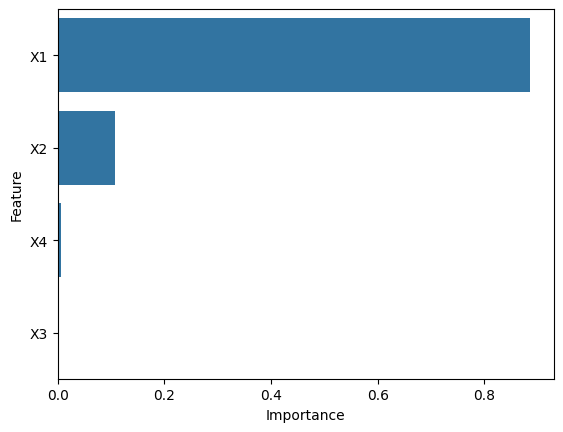

In [35]:
# Ahora grafiquemoslo
feature_importances3_df = feature_importances3_df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importances3_df)

In [36]:
# Guardar Efectos y Decisiones
efectos = pd.DataFrame({'efecto1':efecto1,'efecto3':efecto3,})
decisiones = pd.DataFrame({'decision1':decision1,'decision3':decision3,})

In [37]:
decisiones

,decision1,decision3
0,1,1
1,1,0
2,1,0
3,1,1
4,1,1
...,...,...
4995,1,1
4996,1,0
4997,1,1
4998,1,1


In [38]:
decisiones.to_excel("decisiones_estd3.xlsx", index=True)
efectos.to_excel("efectos_estd3.xlsx", index=True)

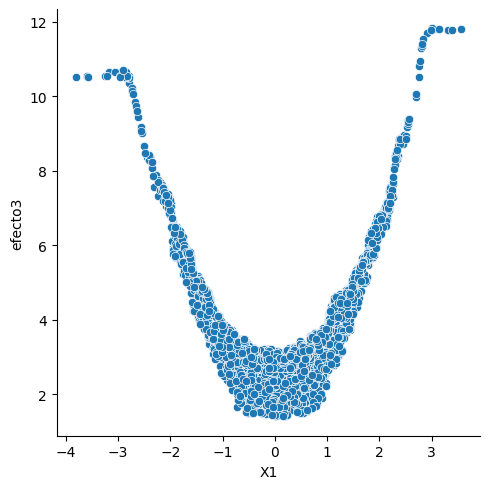

In [39]:
# Cuales son los efectos heterogeneos de acuerdo a los distintos modelos?
# Prueben efecto1, efecto2, efecto3, efecto4. Cual aproxima mejor la verdadera funcion CATE = -2.5 + 5*Abs(X4)
sns.relplot(x=nuevos['X1'],y=efectos['efecto3'])